In [65]:
import os
import numpy as np
import cv2
import matplotlib.pylab as plt
from sklearn.cluster import KMeans
import json
import random

**PATHS**

In [66]:
image_path      = '../../../dataset/images'
training_path   = os.path.join(image_path, 'training')
original_path   = os.path.join(training_path, 'original')
processed_path  = os.path.join(training_path, 'processed')

**LISTAS DE IMAGENES**

In [67]:
original  = [os.path.join(original_path, image) for image in os.listdir(original_path)]
processed  = [os.path.join(processed_path, image) for image in os.listdir(processed_path)]

**RANGOS DE COLOR**

In [68]:
lower_red_2 = np.array([170, 60, 60])
upper_red_2 = np.array([179, 255, 255])

lower_red_1 = np.array([0, 60, 60])
upper_red_1 = np.array([8, 255, 255])

lower_orange = np.array([8, 120, 80])
upper_orange = np.array([21, 255, 255])

lower_yellow = np.array([21, 50, 80])
upper_yellow = np.array([25, 255, 255])

lower_green = np.array([25, 40, 40])
upper_green = np.array([100, 255, 255])

**PRUEBA CON LOS VALORES HSV**
- Utilizando directamente los valores medios de HSV a largo de la imagen en donde la mascara es verdara no funciona
- Probamos utilizar los rangos de color utilizando tambièn los valores medios de h, s, v por imagen pero no funciona

In [69]:
labels  = []
conteos = []

for image_file, mask_file in zip(original, processed):
    # Leer la imagen y la máscara
    image = cv2.imread(image_file)
    mask  = cv2.imread(mask_file, cv2.IMREAD_GRAYSCALE)

    # Convertir la imagen de BGR a HSV
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # Aplicar la máscara
    fruit = cv2.bitwise_and(hsv_image, hsv_image, mask=mask)

    # Contar el número de píxeles en cada rango
    conteo= {
        'V' : np.sum(np.all(np.logical_and(lower_green  <= fruit, fruit <= upper_green), axis=-1)),
        'R1': np.sum(np.all(np.logical_and(lower_red_1  <= fruit, fruit <= upper_red_1), axis=-1)),
        'R2': np.sum(np.all(np.logical_and(lower_red_2  <= fruit, fruit <= upper_red_2), axis=-1)),
        'A' : np.sum(np.all(np.logical_and(lower_yellow <= fruit, fruit <= upper_yellow), axis=-1)),
        'N' : np.sum(np.all(np.logical_and(lower_orange <= fruit, fruit <= upper_orange), axis=-1))
    }
    conteo_por_rango = {
        'V': conteo['V'],
        'R': conteo['R1'] + conteo['R2'],
        'A': conteo['A'],
        'N': conteo['N']
    }

    sorted_conteo = sorted(conteo_por_rango.items(), key=lambda x: x[1], reverse=True)

    # Obtener el segundo elemento más grande
    segundo_mas_grande = sorted_conteo[1]

    # Obtener la etiqueta y el valor del segundo elemento más grande
    etiqueta_segundo_mas_grande = segundo_mas_grande[0]
    valor_segundo_mas_grande    = segundo_mas_grande[1]

    # Obtener la etiqueta basándose en el rango con el mayor conteo
    etiqueta = max(conteo_por_rango, key = conteo_por_rango.get)
    if (etiqueta_segundo_mas_grande == 'R')and(valor_segundo_mas_grande > 0.5*conteo_por_rango[etiqueta]):
        etiqueta = 'R'

    conteos.append(conteo_por_rango)
    labels.append(etiqueta)

In [70]:
clusters = dict.fromkeys(set(labels))
for file, label in zip(original, labels):
    if clusters[label] is None:
        clusters[label] = []
    clusters[label].append(file)

In [71]:
cnts = dict.fromkeys(set(labels))
for conteo, label in zip(conteos, labels):
    if cnts[label] is None:
        cnts[label] = []
    cnts[label].append(conteo)

N


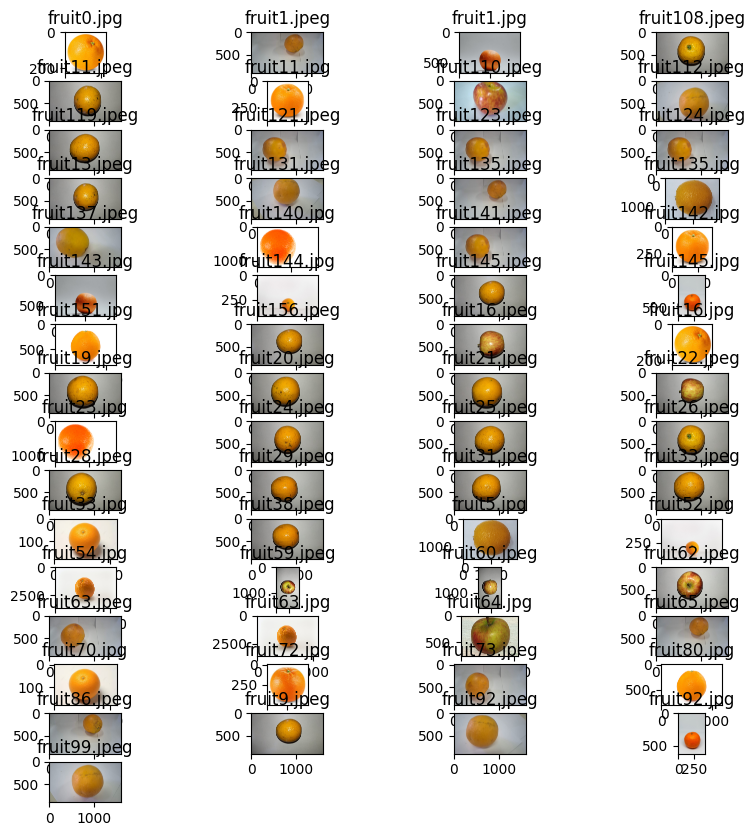

A


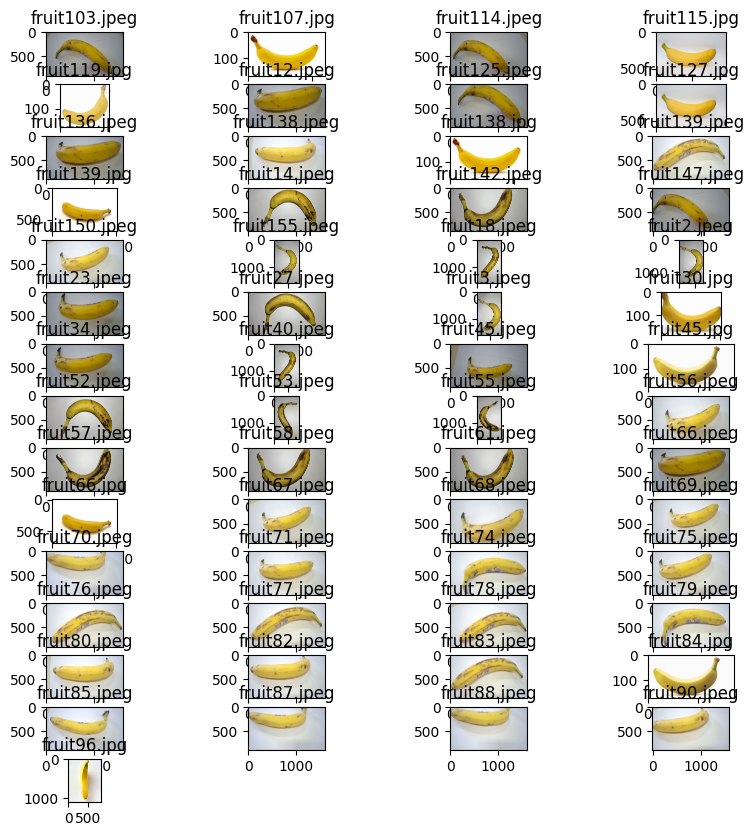

V


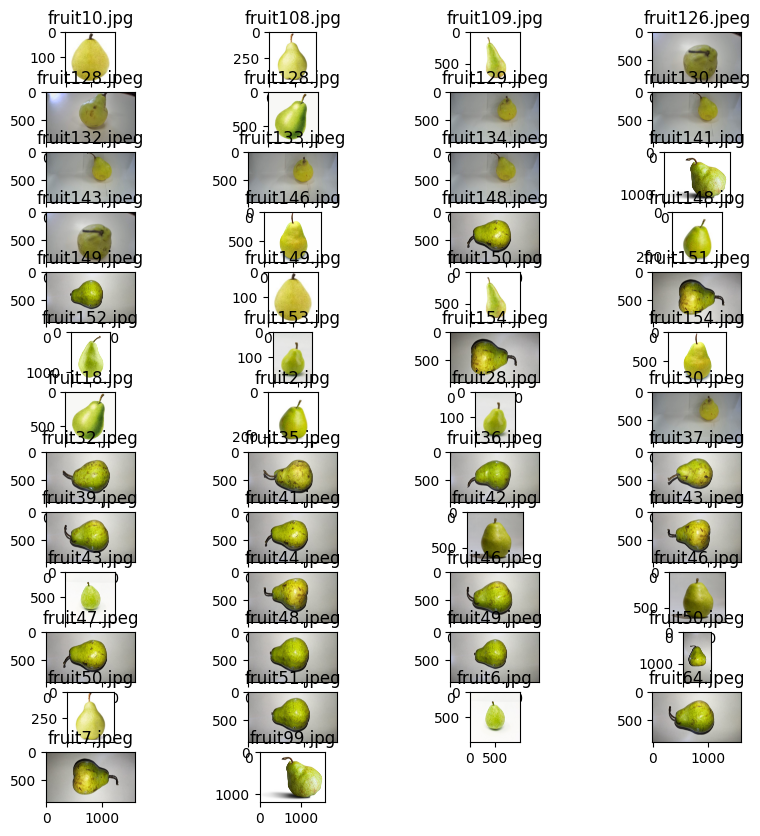

R


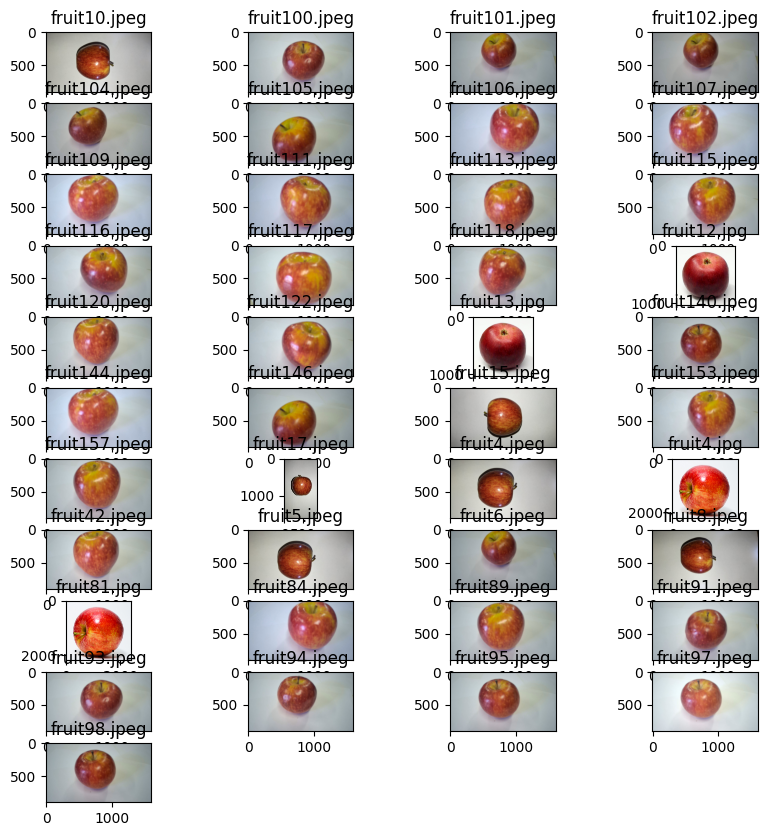

In [72]:
for key, cluster in clusters.items():
    print(key)
    cols = 4
    rows = len(cluster)//cols

    if len(cluster)%cols != 0:
        rows += 1

    plt.figure(figsize = (10, 10))
    for i, element in enumerate(cluster):
        plt.subplot(rows, cols, i + 1)
        plt.imshow(cv2.cvtColor(cv2.imread(element), cv2.COLOR_BGR2RGB))
        plt.title(os.path.basename(element))
    plt.show()